#                           Bollinger Bands Strategy

Strategy Rules
- Buy when the price crosses the lower Bollinger Bands Upwards
- Sell (only if stocks are in possesion) when the prices crosses the upper Bollinger Band Downward
- All in Strategy, when creating a buy order, buy as many shares as possible
- Short Selling is not allowed

In [265]:
# Importing Libraries
import pandas as pd
import yfinance as yf
import statistics
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")


## Downloading data & Setting Bollinger Bands

In [266]:
df=yf.download("^VIX",start="2015-01-01",progress=False)
df["SMA20"]=df["Close"].rolling(20).mean()
df["STD"]=df["Close"].rolling(20).std()
df["BB_Upper"]=df["SMA20"]+(2*df["STD"])  # 2 STD 
df["BB_Lower"]=df["SMA20"]-(2*df["STD"]) # 2 STD
df.head(74)

,Open,High,Low,Close,Adj Close,Volume,SMA20,STD,BB_Upper,BB_Lower
Date,,,,,,,,,,
2015-01-02,17.760000,20.139999,17.049999,17.790001,17.790001,0,NaN,NaN,NaN,NaN
2015-01-05,19.190001,21.290001,19.190001,19.920000,19.920000,0,NaN,NaN,NaN,NaN
2015-01-06,20.330000,22.900000,19.520000,21.120001,21.120001,0,NaN,NaN,NaN,NaN
2015-01-07,20.150000,20.719999,19.040001,19.309999,19.309999,0,NaN,NaN,NaN,NaN
2015-01-08,17.930000,18.090000,16.990000,17.010000,17.010000,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2015-04-14,14.340000,14.740000,13.640000,13.670000,13.670000,0,14.3210,0.927094,16.175189,12.466811
2015-04-15,13.580000,13.580000,12.830000,12.840000,12.840000,0,14.1800,0.927174,16.034349,12.325651
2015-04-16,13.270000,13.350000,12.500000,12.600000,12.600000,0,14.1115,0.991858,16.095215,12.127785


In [267]:
# Execute the strategy and create a Log
signal=0
df_log=pd.DataFrame()
cash=10000
cash_data=[cash]
budget=cash
Buy, Sell = [],[]
for i in range(len(df)):
    if df["Close"].iloc[i-1]<df["BB_Lower"].iloc[i-1] and df["Close"].iloc[i]> df["BB_Lower"].iloc[i]and signal==0:
        Buy.append(i+1)
        signal+=1
        maximo=math.trunc(cash/df["Close"].iloc[i])
        comission=0.01*(maximo*df["Open"].iloc[i+1])
        cash-= maximo*df["Open"].iloc[i+1]+comission
        price=(df["Open"].iloc[i+1])
        # Creating Log
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)
    if df["Close"].iloc[i-1]>df["BB_Upper"].iloc[i-1] and df["Close"].iloc[i]<df["BB_Upper"].iloc[i] and signal ==1:
        Sell.append(i+1)
        signal-=1
        comission=0.01*(maximo*df["Open"].iloc[i+1])
        cash+=maximo*df["Open"].iloc[i+1]-comission
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)   
# you can  only buy an asset in the next signal day opening

## Pure Strategy Log

In [268]:
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Shares",4:"Amount",5:"Comission"})
df_log=df_log.set_index("Date")
df_log=df_log.iloc[::-1]
df_log

,Type,Price,Shares,Amount,Comission
Date,,,,,
2015-06-25,Buy,12.960000,754,9771.840029,97.718400
2015-07-02,Sell,15.430000,754,11634.220230,116.342202
2016-08-09,Buy,11.400000,1029,11730.599607,117.305996
2016-08-29,Sell,14.090000,1029,14498.610157,144.986102
2018-04-19,Buy,15.550000,934,14523.700178,145.237002
2018-05-31,Sell,14.930000,934,13944.620285,139.446203
2018-08-09,Buy,10.940000,1291,14123.539458,141.235395
2018-08-15,Sell,13.520000,1291,17454.320591,174.543206
2019-07-08,Buy,13.730000,1303,17890.189404,178.901894


## Adjusted Strategy Log

In [269]:
# Eliminating Open Positions
Buyprices=df["Open"].iloc[Buy]
Sellprices=df["Open"].iloc[Sell]

if Buyprices.index[-1]>Sellprices.index[-1]:
    cash+=maximo*Buyprices[-1]
    Buyprices=Buyprices.drop(Buyprices.index[-1])
    df_log=df_log[:-1]
    del cash_data[-1]
df_log

,Type,Price,Shares,Amount,Comission
Date,,,,,
2015-06-25,Buy,12.960000,754,9771.840029,97.718400
2015-07-02,Sell,15.430000,754,11634.220230,116.342202
2016-08-09,Buy,11.400000,1029,11730.599607,117.305996
2016-08-29,Sell,14.090000,1029,14498.610157,144.986102
2018-04-19,Buy,15.550000,934,14523.700178,145.237002
2018-05-31,Sell,14.930000,934,13944.620285,139.446203
2018-08-09,Buy,10.940000,1291,14123.539458,141.235395
2018-08-15,Sell,13.520000,1291,17454.320591,174.543206
2019-07-08,Buy,13.730000,1303,17890.189404,178.901894


## Graph with Bollinger Bands

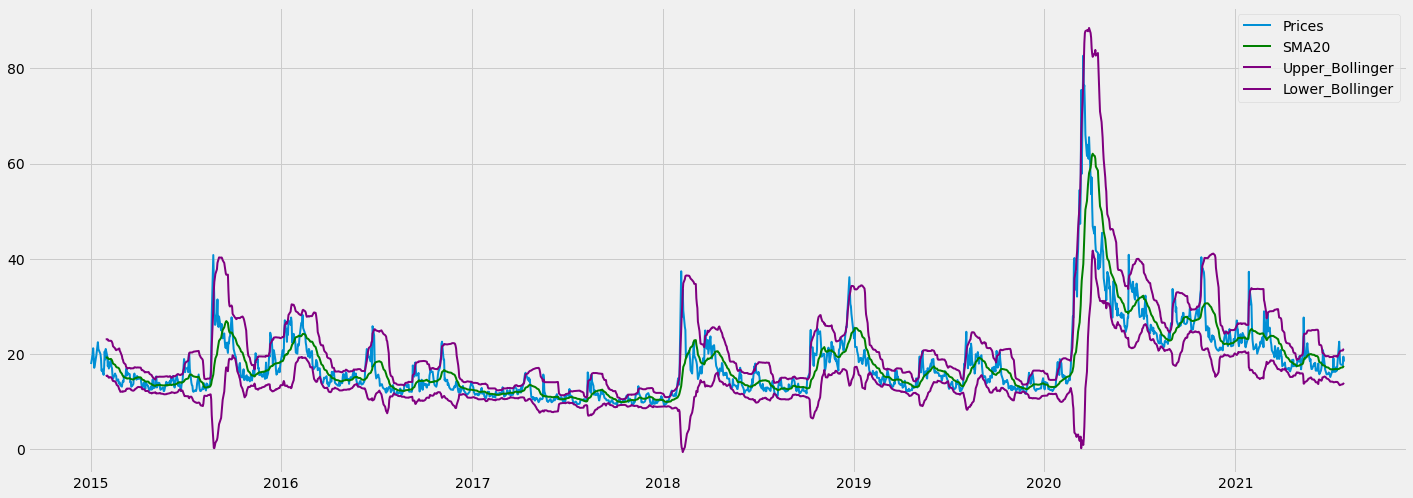

In [270]:
plt.figure(figsize=(22,8))
plt.plot(df["Adj Close"],linewidth=2,label="Prices")
plt.plot(df["SMA20"],linewidth=2,label="SMA20", color="green")
plt.plot(df["BB_Upper"],linewidth=2,label="Upper_Bollinger",color="purple")
plt.plot(df["BB_Lower"],linewidth=2,label="Lower_Bollinger", color="purple")
plt.legend()
plt.show()

## Graph & Execution periods

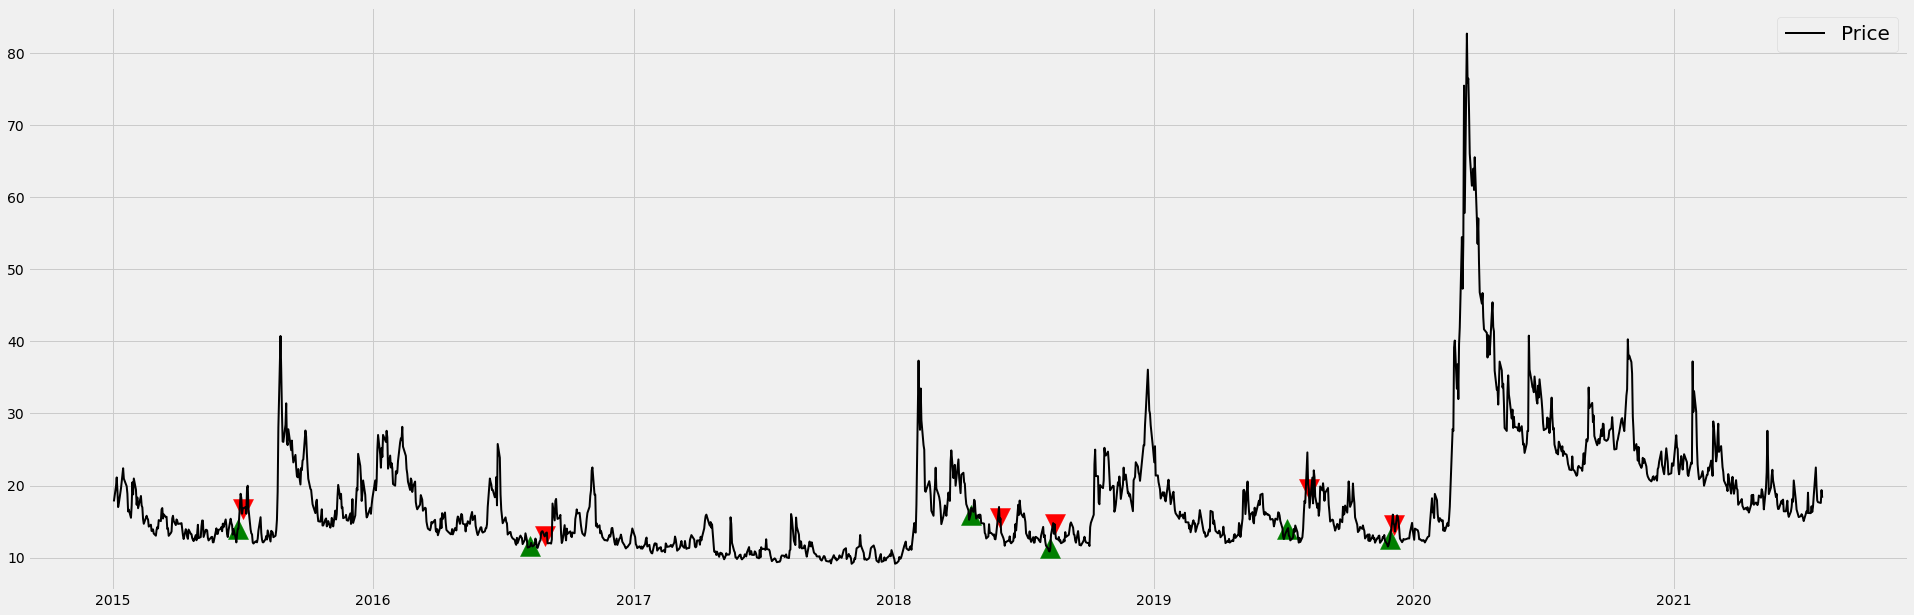

In [271]:
plt.figure(figsize=(30,10))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=400)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=400)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)
# if you want to see bollinger bands, retire the hashtag before the next lines
#plt.plot(df["SMA20"],linewidth=2,label="SMA20", color="green")
#plt.plot(df["BB_Upper"],linewidth=2,label="Upper_Bollinger",color="purple")
#plt.plot(df["BB_Lower"],linewidth=2,label="Lower_Bollinger", color="purple")
#
plt.legend(fontsize=20)
plt.show()


## Budget over time

<AxesSubplot:title={'center':'Budget'}>

<Figure size 1584x576 with 0 Axes>

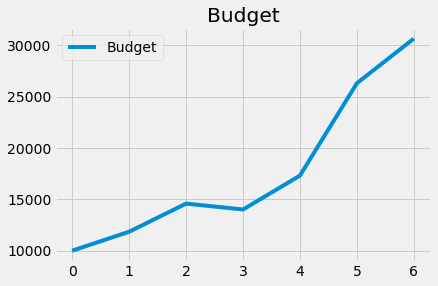

In [272]:
plt.figure(figsize=(22,8))
cash_data=pd.DataFrame(pd.Series(cash_data))
cash_data=cash_data.rename(columns={0:"Budget"})
maximum_loss=min(cash_data["Budget"])
cash_data.plot(title="Budget")

## Strategy Results

In [273]:
B_H=(df["Close"][-1]-df["Close"][0])/df["Close"][0]
B_H
retorno = (cash-budget)/budget
print(f"Initial Cash: ${budget:.2f}")
print(f"Final Cash: ${cash:.2f}")
print(f"Strategy: {retorno*100:.2f}%")
print(f"Simple Buy & Hold Strategy: {B_H*100:.2f}%")
print(f"Maximum Drawdown: {(maximum_loss-budget)/budget*100:.2f}%")


Initial Cash: $10000.00
Final Cash: $30641.98
Strategy: 206.42%
Simple Buy & Hold Strategy: 2.92%
Maximum Drawdown: 0.00%
